## Reading the .csv containing the file names and the steering angles

### Loading the file names  and steering angles into samples
### Splitting samples into train and validation samples

In [1]:
def  extractFileName ( abs_path):

    import os
    if os.name == "nt":
        split_char = '\\' 
    else:
        split_char = '/' 
    if '\\' in abs_path:
        # "  Windows Path " 
        image_name = abs_path.split ('\\')[-3] \
                            + split_char + abs_path.split ('\\')[-2] \
                            + split_char + abs_path.split ('\\')[-1]

    else:
        # "  Unix Path " 
        image_name = abs_path.split ('/')[-3] \
                            + split_char + abs_path.split ('/')[-2] \
                            + split_char + abs_path.split ('/')[-1]

    return image_name

#### Defining the resize shape of the images ( this parameter will be used also in the Generator and in the Model definition)

In [2]:
resized_shape = 128

In [3]:
## LOADING ALL IMAGES CENTER, LEFT, RIGHT IN A TWO DIMENSIONAL ARRAY:
## ( IMAGE, STEERING ANGLE )
## EVERYTHING WILL BE KEPT IN MEMORY TO SPEED DATA FLUSHING BETWEEN CPU AND GPU

In [11]:
import os
import csv
import cv2
import numpy as np
import glob

samples = []
center_image_before = None
for name in glob.glob("./data/*.csv"):
    print ( "Reading from logfile = " + name)
    with open(name)  as csvfile:
            reader = csv.reader(csvfile)
            for line in reader:
                # STEERING ANGLE CALCULATION
                correction = 0.03 # this is a parameter to tune
                center_steering = float(line[3])
                left_steering   = center_steering + correction
                right_steering  = center_steering - correction
                
                # CENTER IMAGE
                center_image = cv2.imread(extractFileName( line[0]))
                center_image = cv2.cvtColor (center_image, cv2.COLOR_BGR2RGB)
                center_image = cv2.resize(center_image,(resized_shape,resized_shape ))
                samples.append([center_image, center_steering ])

                #   LEFT IMAGE
                left_image = cv2.imread(extractFileName( line[1]))
                left_image = cv2.cvtColor (left_image, cv2.COLOR_BGR2RGB)
                left_image = cv2.resize(left_image,(resized_shape,resized_shape ))
                samples.append([left_image, left_steering ])
                
                #   RIGHT IMAGE
                right_image = cv2.imread(extractFileName( line[2]))
                right_image = cv2.cvtColor (right_image, cv2.COLOR_BGR2RGB)
                right_image = cv2.resize(right_image,(resized_shape,resized_shape ))
                samples.append([right_image, right_steering ])

                
                ###
                ### IMAGE AUGMENTATION
                ###
                # augmented center image
                samples.append([cv2.flip(center_image,1), center_steering*-1.0 ])

                # augmented left image
                samples.append([cv2.flip(left_image  ,1), left_steering  *-1.0] )

                # augmented right image
                samples.append([cv2.flip(right_image,1),  right_steering *-1.0] )

                
                ###
                ### IMAGE AUGMENTATION 2 - 
                ### Adding images of frames before... with the actual steering wheel angle
                if center_image_before is not None:
                    samples.append([center_image_before, center_steering ])
 
                center_image_before = center_image
    

samples =np.array(samples)
                
print ("\nTotal samples {}x{} loaded in memory  : {} , size occupied in memory : {} Mb"\
       .format(resized_shape,resized_shape,\
        str(len(samples)*3), int(samples.nbytes/8/1024)) )

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

print ("\nTrain samples = {}".format(train_samples.shape[0]*3))
print ("\nValidation samples  = {}".format(validation_samples.shape[0]*3))


Reading from logfile = ./data/track2_run1.csv
Reading from logfile = ./data/run5.csv
Reading from logfile = ./data/run6.csv
Reading from logfile = ./data/track2_run4.csv
Reading from logfile = ./data/track2_run2.csv
Reading from logfile = ./data/run2.csv
Reading from logfile = ./data/run1.csv
Reading from logfile = ./data/track2_run3.csv
Reading from logfile = ./data/run4.csv
Reading from logfile = ./data/run3.csv
Reading from logfile = ./data/run7.csv

Total samples 128x128 loaded in memory  : 307374 , size occupied in memory : 200 Mb

Train samples = 245898

Validation samples  = 61476


## EXPLORING THE DATA

In [ ]:
samples.shape


Exploring the dataset ...


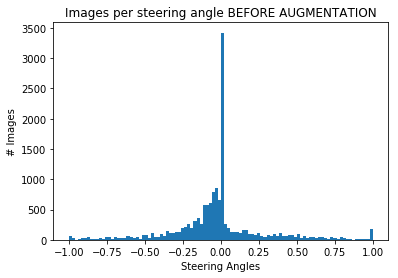

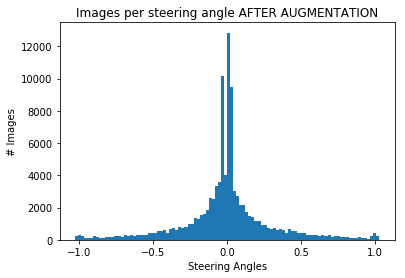

Exploring the dataset complete.


In [12]:
import matplotlib.pyplot as plt
 
print("\nExploring the dataset ...")
 
# It plots the histogram of an arrray of angles: [0.0,0.1, ..., -0.1]
def plot_steering_histogram(steerings, title, num_bins=100):
    plt.hist(steerings, num_bins)
    plt.title(title)
    plt.xlabel('Steering Angles')
    plt.ylabel('# Images')
    plt.show()
 
# It plots the histogram of an arrray of associative arrays of angles: [{'steering':0.1}, {'steering':0.2}, ..., {'steering':-0.1}]
def plot_dataset_histogram(samples, title, num_bins=100):
    steerings = []
    for item in samples:
#         print (item)
        steerings.append( float(item) )
    plot_steering_histogram(steerings, title, num_bins)
 
samples_before = []
for name in glob.glob("./data/*.csv"):
    with open(name)  as csvfile:
            reader = csv.reader(csvfile)
            for line in reader:
                samples_before.append(line[3])

# Plot the histogram of steering angles before the image augmentation
plot_dataset_histogram(samples_before, 'Images per steering angle BEFORE AUGMENTATION', num_bins=100)
samples_before = []

# Plot the histogram of steering angles after the image augmentation
plot_dataset_histogram(samples[:,1], 'Images per steering angle AFTER AUGMENTATION', num_bins=100)
print("Exploring the dataset complete.")

## Defining the generator .
### This flushes the files content from disk and return it to Tensorflow for the training fit
### The generator is repeated many times ( as many Epochs of training )



In [13]:
import cv2
import numpy as np
import sklearn


def generator(generator_samples, batch_size, shape ):
    num_samples = len(generator_samples)
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = generator_samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                
                images.append(batch_sample[0])
                angles.append(batch_sample[1])

            # end of the batch, yield the images gathered
            yield sklearn.utils.shuffle(np.array(images) , np.array(angles))
            #return sklearn.utils.shuffle(X_train ) #, y_train)

## Model definition using Keras

#### NVIDIA model used
#### Image normalization to avoid saturation and make gradients work better.
####     Convolution: 5x5, filter: 24, strides: 2x2, activation: ELU
####     Convolution: 5x5, filter: 36, strides: 2x2, activation: ELU
####     Convolution: 5x5, filter: 48, strides: 2x2, activation: ELU
####     Convolution: 3x3, filter: 64, strides: 1x1, activation: ELU
####     Convolution: 3x3, filter: 64, strides: 1x1, activation: ELU
####     Drop out (0.5)
####     Fully connected: neurons: 100, activation: ELU
####     Fully connected: neurons: 50, activation: ELU
####     Fully connected: neurons: 10, activation: ELU
####     Fully connected: neurons: 1 (output)

In [14]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Activation, Dropout, Reshape
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()
top_crop = int(resized_shape*10/100)
bottom_crop = int(resized_shape*34/100)

# Data Preprocessing ( Normalization and mean centering)
model.add(Cropping2D(cropping =((bottom_crop,top_crop),(0,0)), input_shape = (resized_shape,resized_shape,3), name ="cropping") )
model.add(Lambda(lambda x: x/127.5 - 1. , input_shape = (resized_shape,resized_shape,3)))

model.add(Conv2D(24, (5, 5), activation='elu', padding='valid',strides=(2, 2), name = "Conv1"))

model.add(Conv2D(36, (5, 5), activation='elu', padding='valid',strides=(2, 2), name = "Conv2"))

model.add(Conv2D(48, (5, 5), activation='elu', padding='valid',strides=(2, 2), name = "Conv3"))

model.add(Conv2D(64, (3, 3), activation='elu', padding='valid',strides=(1, 1), name = "Conv4"))
model.add(Conv2D(64, (3, 3), activation='elu', padding='valid',strides=(1, 1), name = "Conv5"))

model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(100, activation='elu',kernel_initializer='random_uniform',bias_initializer='zeros'))
model.add(Dense(50, activation='elu',kernel_initializer='random_uniform',bias_initializer='zeros'))
model.add(Dense(10, activation='elu',kernel_initializer='random_uniform',bias_initializer='zeros'))
model.add(Dense(1,kernel_initializer='random_uniform',bias_initializer='zeros'))

model.compile(loss='mse', optimizer='adam')

print (model.summary())

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping (Cropping2D)        (None, 73, 128, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 73, 128, 3)        0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 35, 62, 24)        1824      
_________________________________________________________________
Conv2 (Conv2D)               (None, 16, 29, 36)        21636     
_________________________________________________________________
Conv3 (Conv2D)               (None, 6, 13, 48)         43248     
_________________________________________________________________
Conv4 (Conv2D)               (None, 4, 11, 64)         27712     
_________________________________________________________________
Conv5 (Conv2D)               (None, 2, 9, 64)          36928     
__________

### Running the training and printing a statistic

#### Defining the batch size and epochs

In [15]:
batch_size = 32
epochs = 10

#### Creating the Train and Validation generators:

In [16]:
train_generator      = generator(train_samples, batch_size, shape=resized_shape)
validation_generator = generator(validation_samples, batch_size, shape=resized_shape)

#### Training the model using traing_generator and validating with validation_generator

Epoch 1/10
2562/2561 [==============================] - 35s - loss: 0.0485 - val_loss: 0.0383
Epoch 2/10
2562/2561 [==============================] - 32s - loss: 0.0379 - val_loss: 0.0320
Epoch 3/10
2562/2561 [==============================] - 33s - loss: 0.0325 - val_loss: 0.0293
Epoch 4/10
2562/2561 [==============================] - 33s - loss: 0.0283 - val_loss: 0.0258
Epoch 5/10
2562/2561 [==============================] - 32s - loss: 0.0252 - val_loss: 0.0232
Epoch 6/10
2562/2561 [==============================] - 32s - loss: 0.0231 - val_loss: 0.0217
Epoch 7/10
2562/2561 [==============================] - 32s - loss: 0.0213 - val_loss: 0.0232
Epoch 8/10
2562/2561 [==============================] - 32s - loss: 0.0205 - val_loss: 0.0195
Epoch 9/10
2562/2561 [==============================] - 33s - loss: 0.0194 - val_loss: 0.0196
Epoch 10/10
2562/2561 [==============================] - 32s - loss: 0.0185 - val_loss: 0.0184

Total number of train samples: 81966 ( shape 128x128)

Bat

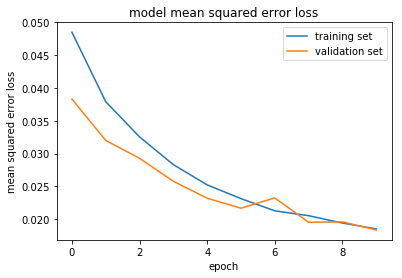

In [17]:
from datetime import datetime
start_time = datetime.now()

model.compile(loss='mse', optimizer='adam')

numper_of_train_samples      = len(train_samples)
number_of_validation_samples = len(validation_samples) 

history_object = model.fit_generator(train_generator, steps_per_epoch= \
            numper_of_train_samples/batch_size, validation_data=validation_generator, \
            validation_steps=number_of_validation_samples/batch_size, epochs=10, verbose = 1)

end_time = datetime.now()
print('\nTotal number of train samples: {} ( shape {}x{})'.format(numper_of_train_samples,resized_shape,resized_shape))
print('\nBatch Size                   : {}'.format(batch_size))
print('\nDuration                     : {}'.format(end_time - start_time))

from keras.models import save_model

save_model(model, "drive.h5")
print ( "  ")
print ( " .. model saved to drive.h5 ")
print ( "  ")


### print the keys contained in the history object
print(history_object.history.keys())

import matplotlib.pyplot as plt
# # # Visualizations will be shown in the notebook.
%matplotlib inline

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()


#### Image Convolution broken down in small pieces 

### Here I am trying to visualize the Convolution Layers to understand visually how many filters I should use

In [ ]:
print (" Loading drive.h5 .......")

from keras.models import load_model
from keras.models import Model

modelobj = load_model('drive.h5')
print (" ..... model drive.h5 successfully loaded")


#### For this purpose I am loading a Test image from disk

In [29]:
# Load test images
import cv2
import numpy as np
test_images = []

image = cv2.imread('./test_images/center1.jpg')
image = cv2.cvtColor (image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image,(resized_shape,resized_shape ))     
test_images.append(image)


test_images = np.array(test_images)


#### First of all I am looking at the Image Crop if is well done in the right position:

In [30]:
# Call the model to calculate an intermediate layer using the test images
layer_name = 'cropping'
intermediate_layer_model = Model(inputs=modelobj.input,
                                 outputs=modelobj.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(test_images)
intermediate_output.shape


(1, 73, 128, 3)

(73, 128, 3)


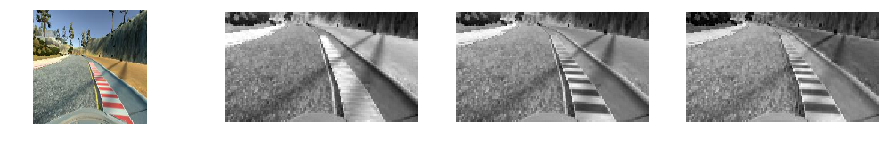

In [31]:
# Show the cropped images
def show_intermediate_output(image_ori, intermediate_output):
    print (intermediate_output.shape)
    depth = 0 
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.figure(figsize=(20, 100))
    new_image = []
    plt.subplot(40, 5, 1 )
    plt.axis('off')
    plt.imshow(image_ori)
    for i in range(0,intermediate_output[0,0].shape[0]):
           single_output = intermediate_output[:,:,i]
#            print ( "single_output.shape {}".format(single_output.shape ))
#            print ( single_output)
           plt.subplot(40, 5, i+2 )
           plt.axis('off')
           single_output = single_output.astype(np.uint8)
           plt.imshow(single_output, cmap='gray')
    plt.show()    

    
show_intermediate_output(test_images[0], intermediate_output[0])

#### Now the FIRST convolutional layer:

/home/cristianku/anaconda3/envs/carnd-term1-gpu/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("Co..., inputs=Tensor("cr...)`
  after removing the cwd from sys.path.


(35, 62, 24)


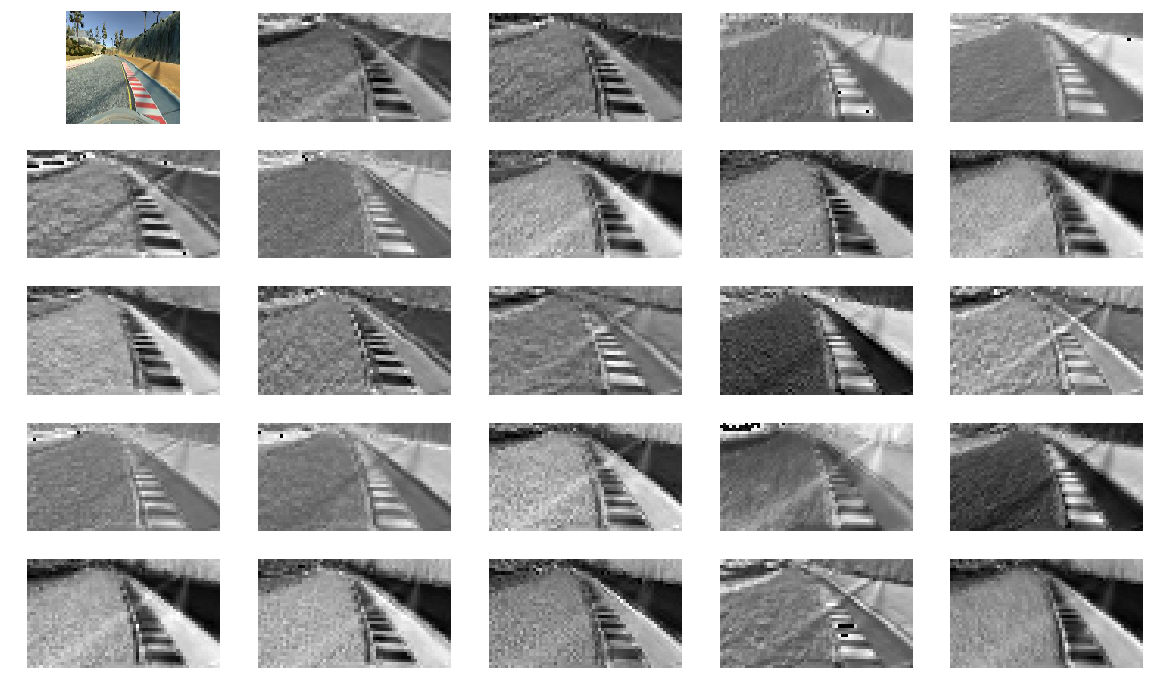

In [32]:
# Call the model to calculate an intermediate layer using the test images
layer_name = 'Conv1'
intermediate_layer_model = Model(input=model.input,
                                 output=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(test_images)
int_unNorm = (intermediate_output[0]+1) * 127.5
show_intermediate_output(test_images[0], int_unNorm ) 
                            
            

#### Now the SECOND convolutional layer:

/home/cristianku/anaconda3/envs/carnd-term1-gpu/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("Co..., inputs=Tensor("cr...)`
  after removing the cwd from sys.path.


(16, 29, 36)


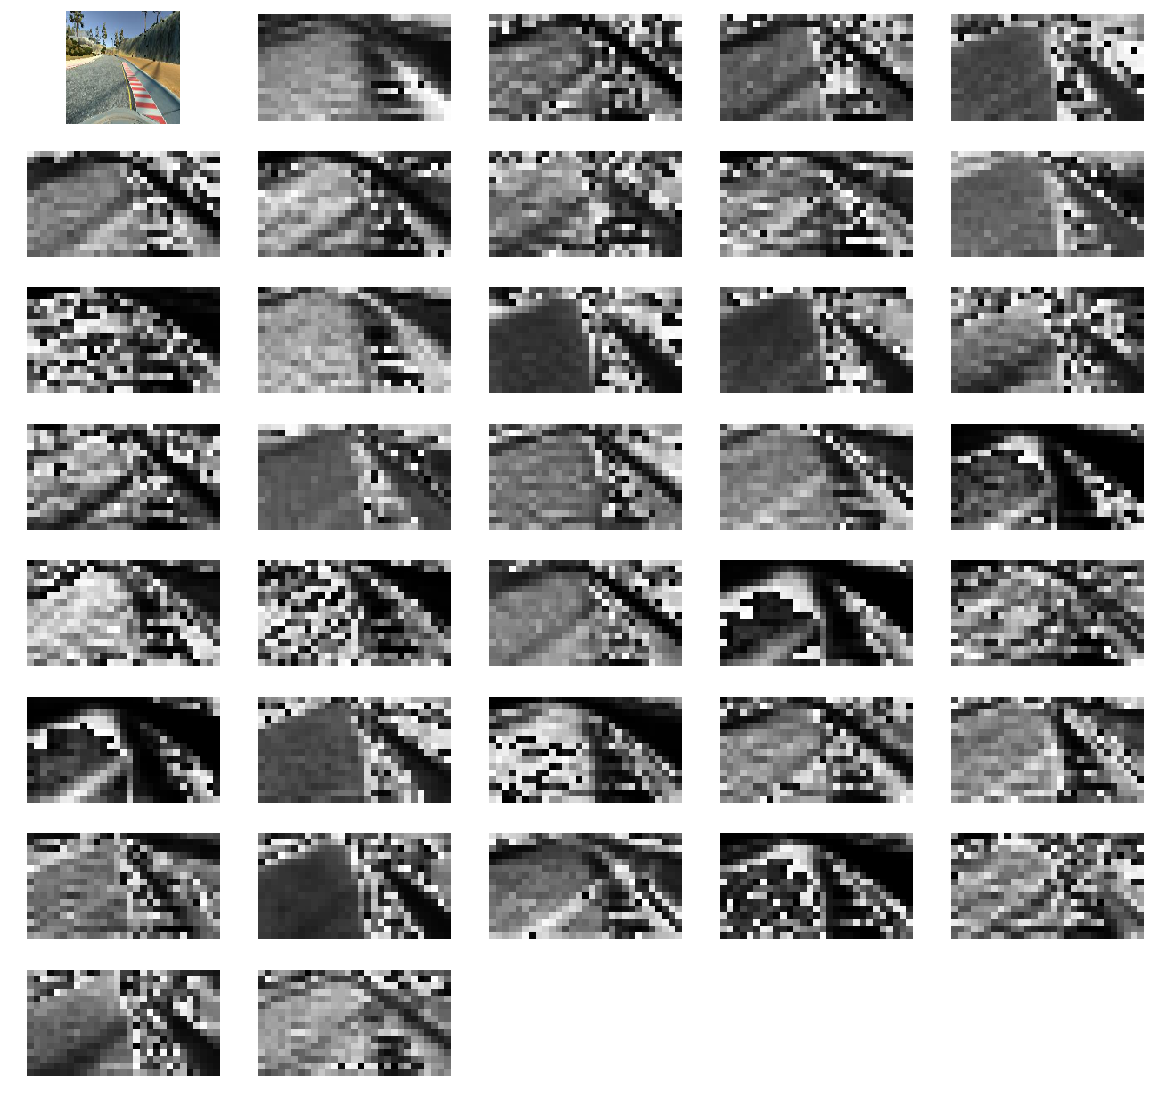

In [33]:
# Call the model to calculate an intermediate layer using the test images
layer_name = 'Conv2'
intermediate_layer_model = Model(input=model.input,
                                 output=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(test_images)
int_unNorm = (intermediate_output[0]+1) * 127.5
show_intermediate_output(test_images[0], int_unNorm ) 
                            
            

### Conv 3

/home/cristianku/anaconda3/envs/carnd-term1-gpu/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("cr..., outputs=Tensor("Co...)`
  after removing the cwd from sys.path.


(4, 7, 64)


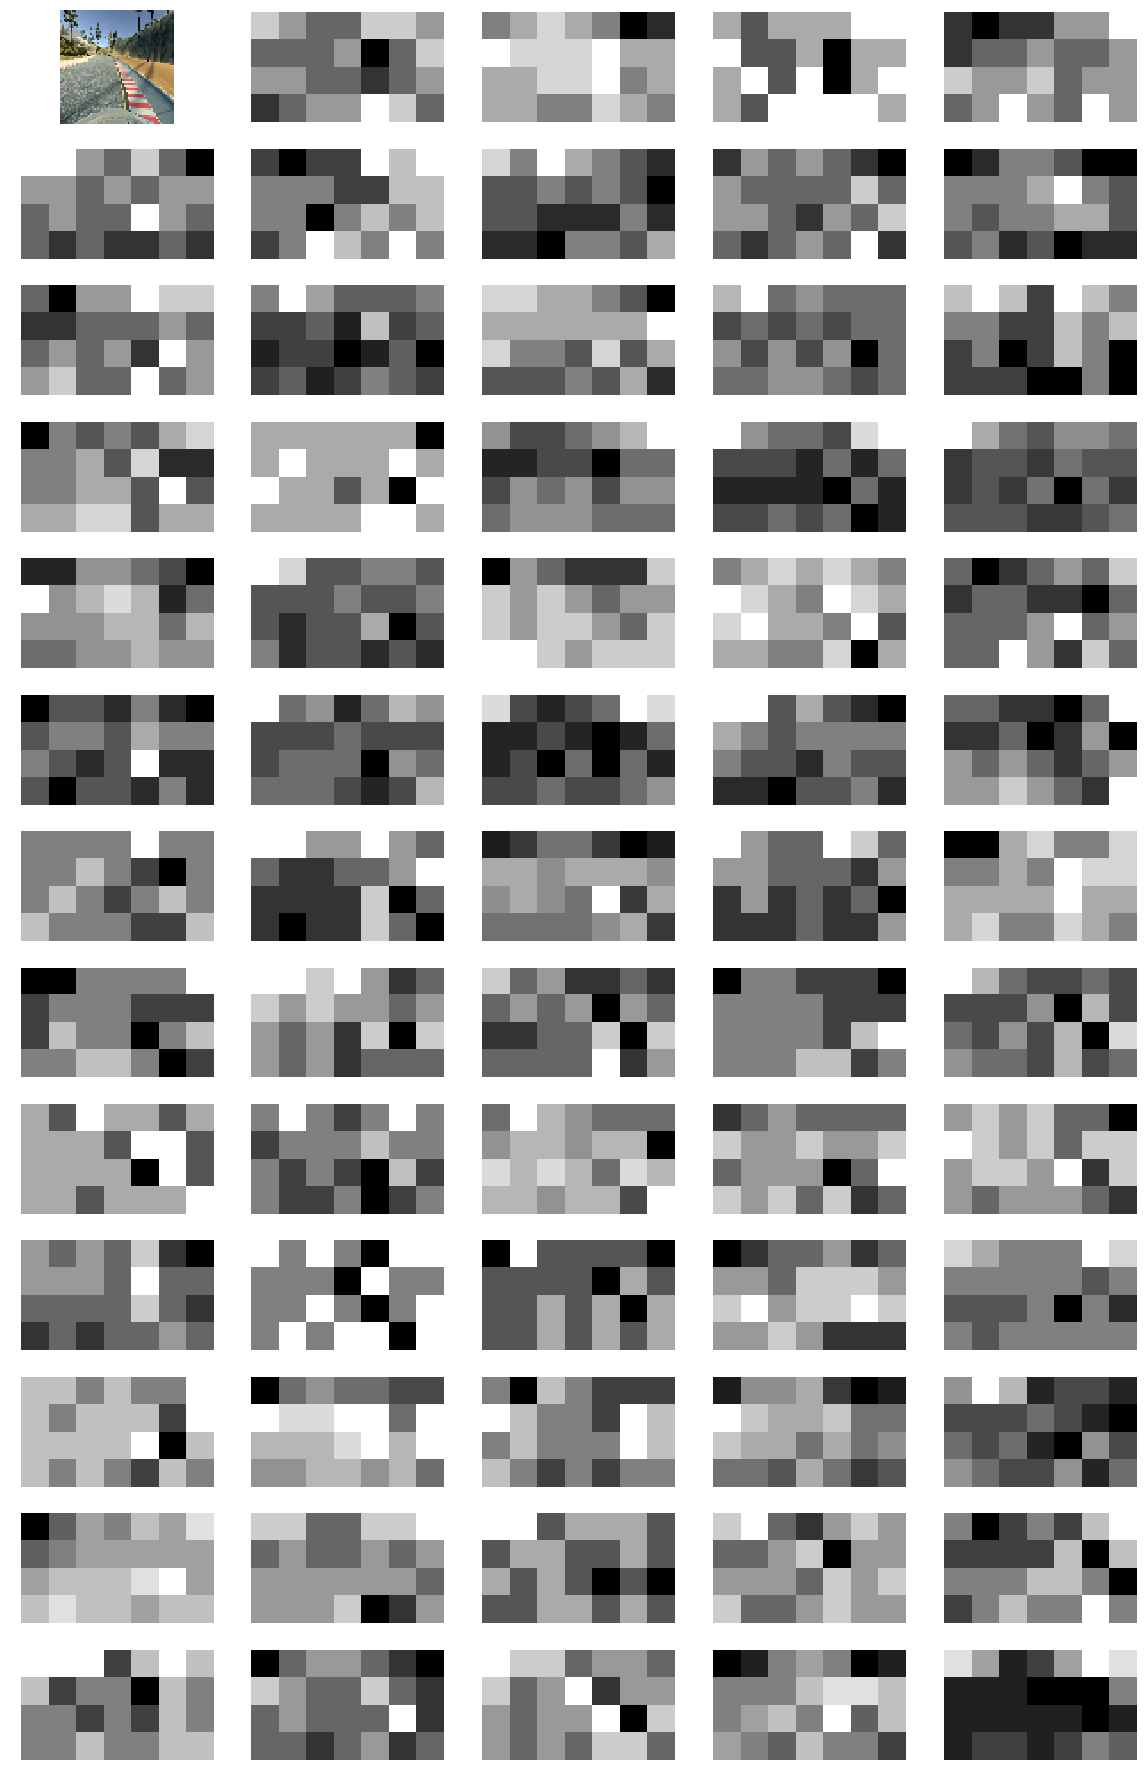

In [171]:
# Call the model to calculate an intermediate layer using the test images
layer_name = 'Conv3'
intermediate_layer_model = Model(input=model.input,
                                 output=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(test_images)
int_unNorm = (intermediate_output[0]+1) * 127.5
show_intermediate_output(test_images[0], int_unNorm ) 
                            
            

### Conv 4

/home/cristianku/anaconda3/envs/carnd-term1-gpu/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("cr..., outputs=Tensor("Co...)`
  after removing the cwd from sys.path.


(4, 7, 128)


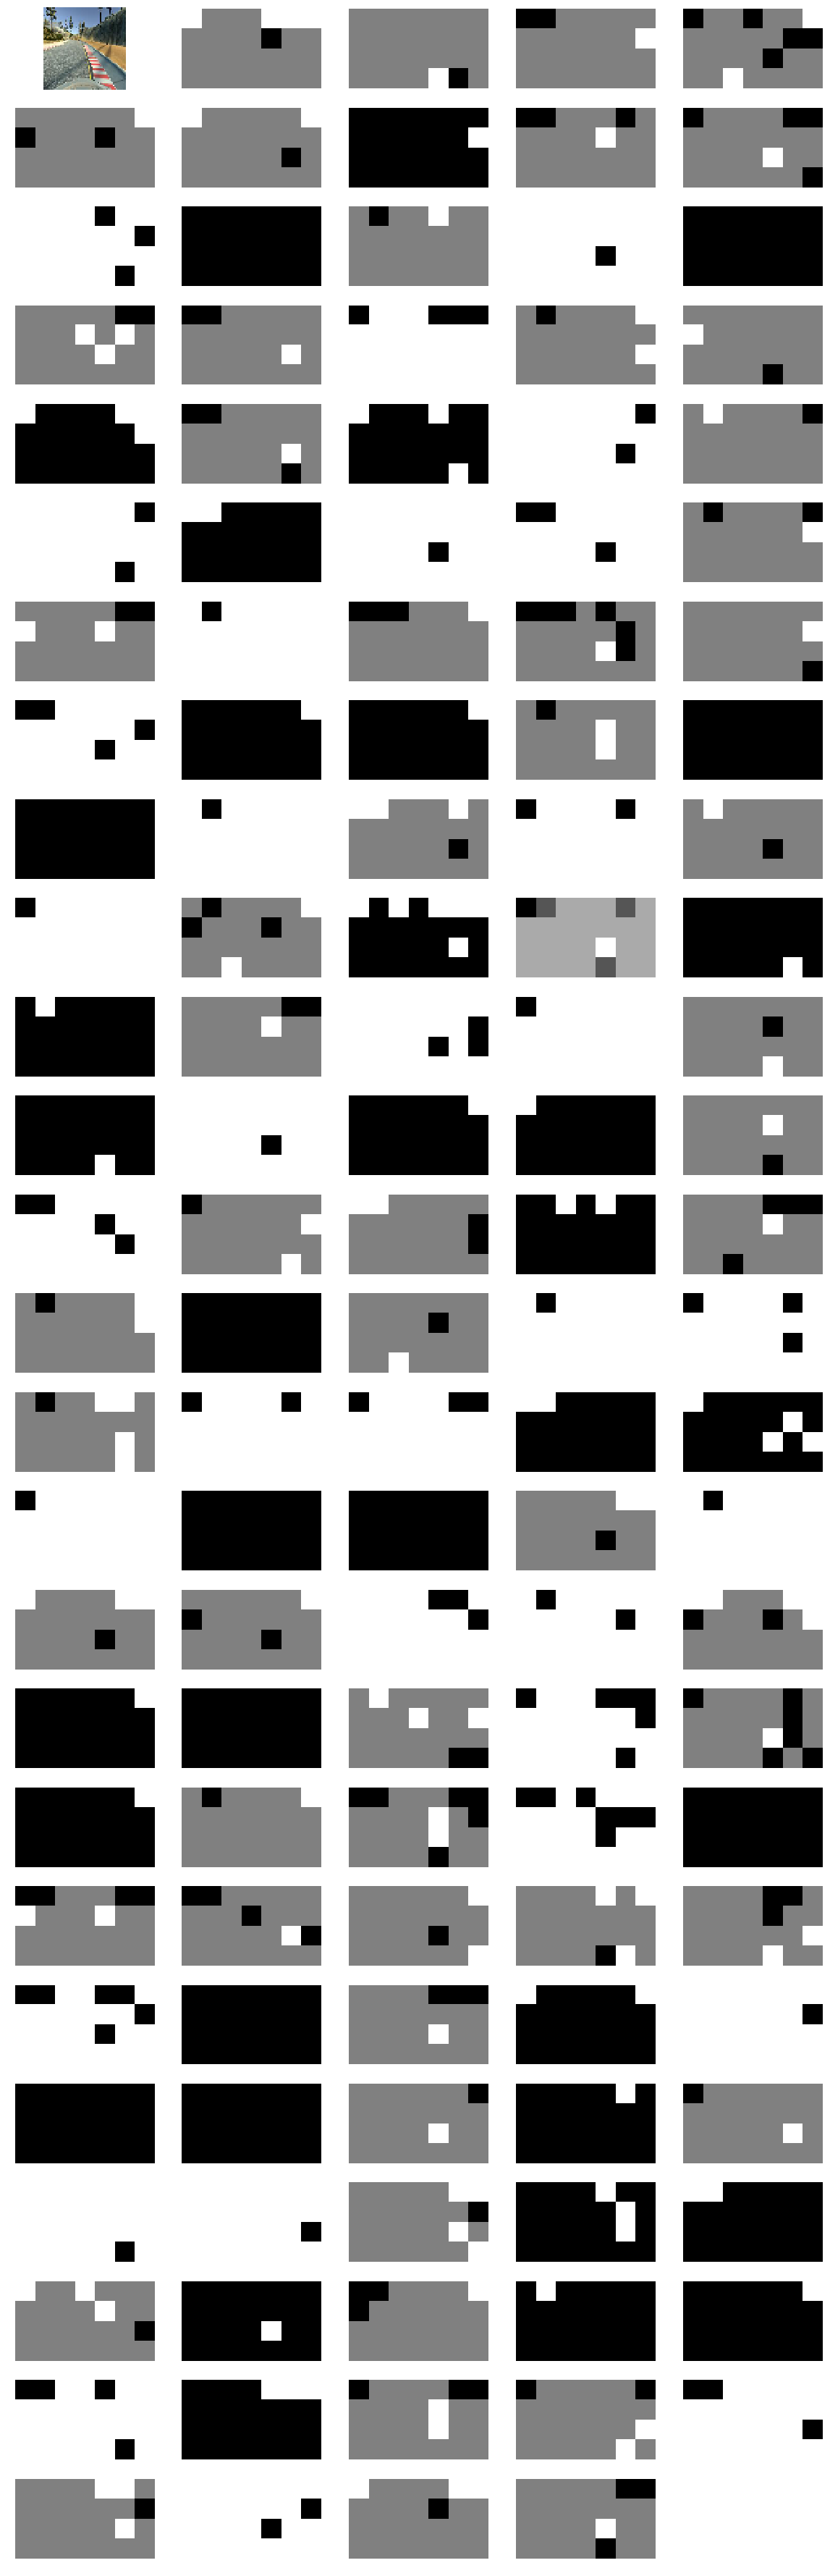

In [172]:
# Call the model to calculate an intermediate layer using the test images
layer_name = 'Conv4'
intermediate_layer_model = Model(input=model.input,
                                 output=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(test_images)
int_unNorm = (intermediate_output[0]+1) * 127.5
show_intermediate_output(test_images[0], int_unNorm ) 
                            
            

### Model Visualization

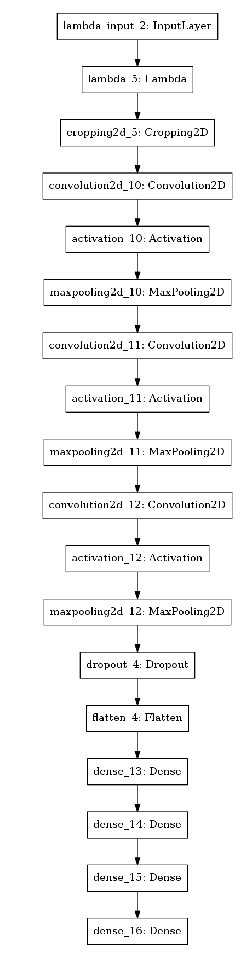

In [11]:
import cv2
from keras.utils.visualize_util import plot
from keras.models import load_model
%matplotlib inline

#visualize the model
modelobj = load_model('model.h5')
plot (modelobj, to_file='model.png')
import matplotlib.pyplot as plt

plt.figure(figsize=(100, 100))
image = cv2.imread('model.png')
image = cv2.cvtColor (image, cv2.COLOR_BGR2RGB)
plt.subplot(5, 5, 1)
plt.axis('off')

plt.imshow(image)
plt.show()
